In [15]:
from imutils import paths
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Flatten, Dense, AveragePooling2D, Dropout, Input, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [16]:
# train_data = []
# test_data = []
# val_data = []
data = []

# train_labels = []
# test_labels = []
# val_labels = []
labels = []

train_dir = Path('../artifacts/data_ingestion/train')
test_dir = Path('../artifacts/data_ingestion/test')
valid_dir = Path('../artifacts/data_ingestion/valid')

# populating train data
for subdir in ['DR','No_DR']:
    subdir_path = os.path.join(train_dir,subdir)

    for file in os.listdir(subdir_path):
        image_path = os.path.join(subdir_path,file)
        
        image = cv2.imread(image_path)
        image = img_to_array(image)
        
        # resizing the image according to the size specification of Xception (original size - (224,224), resized to - (128,128))
        image = cv2.resize(image, (128,128))
        data.append(image)

        labels.append(subdir)

# populating test data
for subdir in ['DR','No_DR']:
    subdir_path = os.path.join(test_dir,subdir)

    for file in os.listdir(subdir_path):
        image_path = os.path.join(subdir_path,file)
        
        image = cv2.imread(image_path)
        image = img_to_array(image)

        # resizing the image according to the size specification of Xception (original size - (224,224), resized to - (128,128))
        image = cv2.resize(image, (128,128))
        data.append(image)

        labels.append(subdir)
        
# populating validation data
for subdir in ['DR','No_DR']:
    subdir_path = os.path.join(valid_dir,subdir)

    for file in os.listdir(subdir_path):
        image_path = os.path.join(subdir_path,file)
        
        image = cv2.imread(image_path)
        image = img_to_array(image)

        # resizing the image according to the size specification of Xception (original size - (224,224), resized to - (128,128))
        image = cv2.resize(image, (128,128))
        data.append(image)

        labels.append(subdir)

In [17]:
print("Length of data:", len(data))
print("Length of labels:", len(labels))
print('\n')

Length of data: 2838
Length of labels: 2838




In [18]:
# Converting the data and labels to numpy arrays and normalizing it
data = np.asarray(data) / 255
labels = np.asarray(labels)

data.shape

(2838, 128, 128, 3)

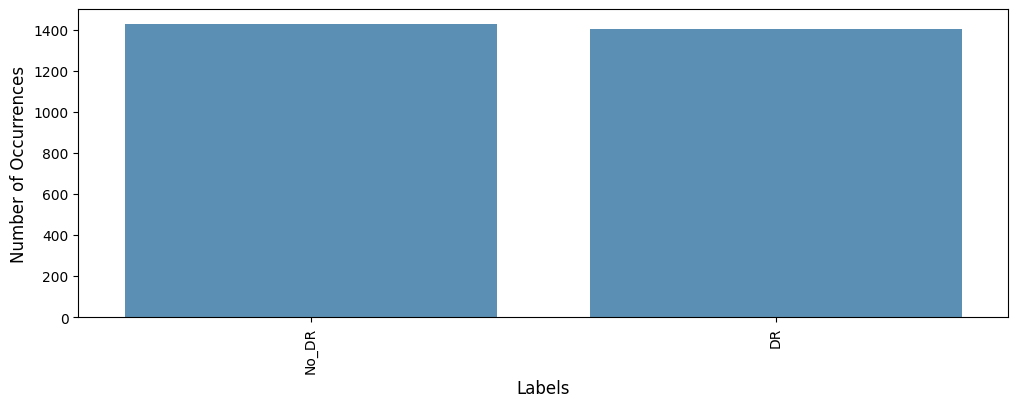

In [19]:
# Training Class distribution
df = pd.DataFrame(labels, columns=["Labels"])
counts = df["Labels"].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [20]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)
labels = to_categorical(le.transform(labels),2)

Since the classes are balanced, there is no need to assign weights to the classes

In [21]:
# Splitting the data into train, test, and valid
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=42)

x_train = x_train[:-round(len(x_train)/10)]
y_train = y_train[:-round(len(y_train)/10)]
x_val = x_train[-round(len(x_train)/10):]
y_val = y_train[-round(len(y_train)/10):]

In [22]:
print(f"Train data: {len(x_train)}")
print(f"Test data: {len(x_test)}")
print(f"Validation data: {len(x_val)}")

Train data: 2043
Test data: 568
Validation data: 204


In [23]:
print(f'Size of training images {x_train.shape}')
print(f'Size of testing images {x_test.shape}')
print(f'Size of validation images {x_val.shape}')

Size of training images (2043, 128, 128, 3)
Size of testing images (568, 128, 128, 3)
Size of validation images (204, 128, 128, 3)


# Xception

In [24]:
# loading pre-trained Xception model
keras_xception = Xception(weights='imagenet',include_top=False, input_shape=x_train.shape[1:4])

# creating custom FC layers
head = keras_xception.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_xception.input, outputs=head)

# Training with SGD Optimizer

In [25]:
# Freezing the pre-trained layers so that their weights don't get updated
for layer in keras_xception.layers:
    layer.trainable = False

lr = 0.001
momentum = 0.9
nesterov = True
epochs = 5
optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=32)

Epoch 1/5
64/64 [==============================] - 81s 1s/step - loss: 0.4207 - accuracy: 0.8164 - val_loss: 0.1812 - val_accuracy: 0.9461
Epoch 2/5
64/64 [==============================] - 71s 1s/step - loss: 0.2338 - accuracy: 0.9139 - val_loss: 0.1376 - val_accuracy: 0.9510
Epoch 3/5
64/64 [==============================] - 68s 1s/step - loss: 0.1998 - accuracy: 0.9305 - val_loss: 0.1115 - val_accuracy: 0.9608
Epoch 4/5
64/64 [==============================] - 72s 1s/step - loss: 0.1781 - accuracy: 0.9388 - val_loss: 0.0980 - val_accuracy: 0.9657
Epoch 5/5
64/64 [==============================] - 72s 1s/step - loss: 0.1685 - accuracy: 0.9476 - val_loss: 0.0871 - val_accuracy: 0.9657


# Training with Adam Optimizer

In [26]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=32)

Epoch 1/5
64/64 [==============================] - 74s 1s/step - loss: 0.5036 - accuracy: 0.8488 - val_loss: 0.1042 - val_accuracy: 0.9755
Epoch 2/5
64/64 [==============================] - 71s 1s/step - loss: 0.2059 - accuracy: 0.9207 - val_loss: 0.0631 - val_accuracy: 0.9853
Epoch 3/5
64/64 [==============================] - 70s 1s/step - loss: 0.1627 - accuracy: 0.9408 - val_loss: 0.0645 - val_accuracy: 0.9755
Epoch 4/5
64/64 [==============================] - 70s 1s/step - loss: 0.1521 - accuracy: 0.9452 - val_loss: 0.0499 - val_accuracy: 0.9853
Epoch 5/5
64/64 [==============================] - 68s 1s/step - loss: 0.1415 - accuracy: 0.9501 - val_loss: 0.0364 - val_accuracy: 0.9902


## Plotting training and valid accuracy and loss

Training Accuracy: 95.0
Validation Accuracy: 99.0


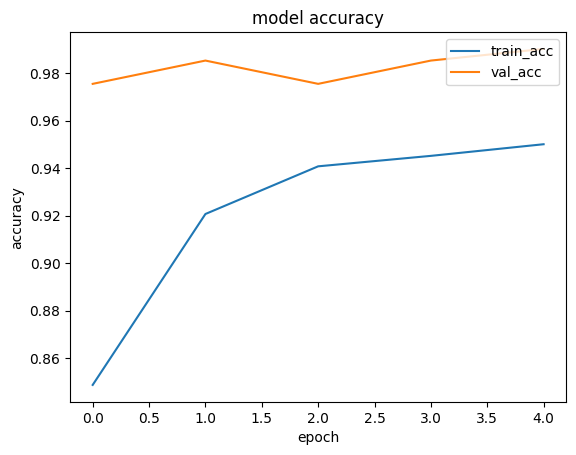

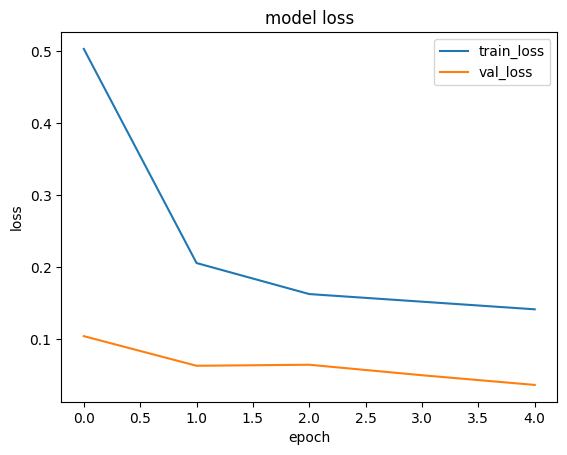

In [27]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

Both accuracy and loss seems good and there are no signs of overfitting

## Xception Report

In [28]:
# Test set accuracy and report (with other metrics)
predictions = model.predict(x_test,batch_size=32)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1),target_names=le.classes_))

18/18 [==============================] - 19s 1s/step
              precision    recall  f1-score   support

          DR       0.97      0.91      0.94       291
       No_DR       0.92      0.97      0.94       277

    accuracy                           0.94       568
   macro avg       0.94      0.94      0.94       568
weighted avg       0.95      0.94      0.94       568

